# Import libraries and dataset

In [1]:
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [2]:
X_train = pd.read_csv('../datasets/X_train_clean.csv')
X_test = pd.read_csv('../datasets/X_test_clean.csv')
y_train = pd.read_csv('../datasets/y_train.csv')
y_test = pd.read_csv('../datasets/y_test.csv')

# Modeling

We need to calculate baseline accuracy in order to tell if our model is better than null model (predicting the plurality class).

In [3]:
y_test.value_counts(normalize=True)

subreddit
1            0.5
0            0.5
dtype: float64

Our model needs to beat 50% accuracy since the distribution between the two target class is 50:50.

In [4]:
X_train = list(X_train['comments'])
X_test = list(X_test['comments'])

y_train = list(y_train['subreddit'])
y_test = list(y_test['subreddit'])

Here we add in extra stop words to filter out synonymous words that's similar to `gainit` and `loseit`.   

*Note that we initially only included 'gainit' and 'loseit' as stop words but it turns out that alot of synonymous words were chosen by our model for r/Loseit like 'lose', 'loss' and 'lost'.*

In [5]:
stop_words_final = text.ENGLISH_STOP_WORDS.union(['gainit', 'loseit', 'lose', 'gain', 'loss', 'lost'])

## Model 1: CountVectorizer, LogReg

Create Pipeline for CountVectorizer and LogisticRegression. 

In [6]:
pipe1 = Pipeline([
    ('cv1', CountVectorizer(stop_words=stop_words_final)),
    ('lr1', LogisticRegression(solver = 'lbfgs'))
])

pipe1_params = {
    'cv1__min_df': [1, 2],
    'cv1__max_df': [0.95, 0.9, 0.85],
    'cv1__ngram_range': [(1,1), (1,2)]
}

gs_pipe1 = GridSearchCV(
    pipe1, 
    param_grid= pipe1_params,
    cv=5
)

Fit model

In [7]:
gs_pipe1.fit(X_train, y_train);

Find best parameters

In [8]:
gs_pipe1.best_params_

{'cv1__max_df': 0.95, 'cv1__min_df': 2, 'cv1__ngram_range': (1, 2)}

Score on best parameters

In [9]:
gs_model_pipe1 = gs_pipe1.best_estimator_
gs_model_pipe1.score(X_train, y_train)

1.0

In [10]:
gs_model_pipe1.score(X_test, y_test)

0.9096638655462185

### Metrics and scores

Create a dataframe to store results

In [11]:
df_results = pd.DataFrame(index=['Model 1', 'Model 2', 'Model 3', 'Model 4'], 
                          columns=['Accuracy', 'Sensitivity', 'Specificity', 'Precision'])

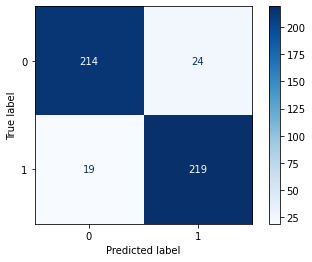

In [12]:
preds_pipe1 = gs_model_pipe1.predict(X_test)
plot_confusion_matrix(gs_model_pipe1, X_test, y_test, cmap='Blues', values_format='d');

Find out the scores

In [13]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_pipe1).ravel()

print("\nAccuracy: ", (tn + tp) / (tn + fp + fn + tp))
df_results.loc[['Model 1'],['Accuracy']] = (tn + tp) / (tn + fp + fn + tp)

print("Sensitivity: ", tp / (tp + fn))
df_results.loc[['Model 1'],['Sensitivity']] = tp / (tp + fn)

print("Specificity: ", tn / (tn + fp))
df_results.loc[['Model 1'],['Specificity']] = tn / (tn + fp)

print("Precision: ", tp / (tp + fp))
df_results.loc[['Model 1'],['Precision']] = tp / (tp + fp)


Accuracy:  0.9096638655462185
Sensitivity:  0.9201680672268907
Specificity:  0.8991596638655462
Precision:  0.9012345679012346


We observe some overfitting on the train dataset as the accuracy score dropped about 10% on the test set. 90% accuracy is a good score considering that the baseline score to beat is 50%. Next, we want to try Logistic Regression with TF-IDF Vectorizer to see if there's significant improvement on a different transformer.

## Model 2: TfidfVectorizer, LogReg

Create Pipeline for TfidfVectorizer and LogisticRegression

In [14]:
pipe2 = Pipeline([
    ('tv2', TfidfVectorizer(stop_words=stop_words_final)),
    ('lr2', LogisticRegression(solver = 'lbfgs'))
])

pipe2_params = {
    'tv2__min_df': [1, 2, 3],
    'tv2__max_df': [0.95, 0.9, 0.85],
    'tv2__ngram_range': [(1,1), (1,2)],
}

gs_pipe2 = GridSearchCV(
    pipe2, 
    param_grid= pipe2_params,
    cv=5
)

Fit model

In [15]:
gs_pipe2.fit(X_train, y_train);

Best parameters

In [16]:
gs_pipe2.best_params_

{'tv2__max_df': 0.95, 'tv2__min_df': 3, 'tv2__ngram_range': (1, 2)}

In [17]:
gs_model_pipe2 = gs_pipe2.best_estimator_
gs_model_pipe2.score(X_train, y_train)

0.9637305699481865

In [18]:
gs_model_pipe2.score(X_test, y_test)

0.9117647058823529

### Metrics and scores

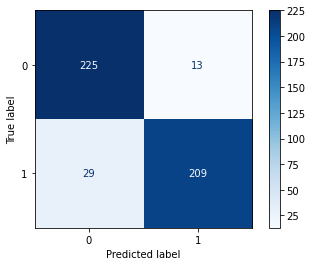

In [19]:
preds_pipe2 = gs_model_pipe2.predict(X_test)
plot_confusion_matrix(gs_model_pipe2, X_test, y_test, cmap='Blues', values_format='d');

Find out the scores

In [20]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_pipe2).ravel()

print("\nAccuracy: ", (tn + tp) / (tn + fp + fn + tp))
df_results.loc[['Model 2'],['Accuracy']] = (tn + tp) / (tn + fp + fn + tp)

print("Sensitivity: ", tp / (tp + fn))
df_results.loc[['Model 2'],['Sensitivity']] = tp / (tp + fn)

print("Specificity: ", tn / (tn + fp))
df_results.loc[['Model 2'],['Specificity']] = tn / (tn + fp)

print("Precision: ", tp / (tp + fp))
df_results.loc[['Model 2'],['Precision']] = tp / (tp + fp)


Accuracy:  0.9117647058823529
Sensitivity:  0.8781512605042017
Specificity:  0.9453781512605042
Precision:  0.9414414414414415


Overall we see lesser overfit as compared to Model 1 with a 5% drop in accuracy on the train versus the test dataset. We also observe that TF-IDF Vectorizer performed better, and perhaps intuitively so since it takes into account the number of occurences of words. We will perform analysis on the features in Section 2.6 since this model is our model of choice.

## Model 3: TfidfVectorizer, MultinomialNB

In [21]:
pipe3 = Pipeline([
    ('tv3', TfidfVectorizer(stop_words=stop_words_final)),
    ('mn3', MultinomialNB())
])

pipe3_params = {
    'mn3__alpha': [1, 1.2, 1.4],
    'tv3__min_df': [1, 2, 3],
    'tv3__max_df': [0.95, 0.9, 0.8, 0.7],
    'tv3__ngram_range': [(1,1), (1,2)]
}

gs_pipe3 = GridSearchCV(
    pipe3,
    param_grid=pipe3_params,
    cv=5
)

Fit model

In [22]:
gs_pipe3.fit(X_train, y_train);

Best parameters

In [23]:
gs_pipe3.best_params_

{'mn3__alpha': 1,
 'tv3__max_df': 0.95,
 'tv3__min_df': 3,
 'tv3__ngram_range': (1, 2)}

In [24]:
gs_model_pipe3 = gs_pipe3.best_estimator_
gs_model_pipe3.score(X_train, y_train)

0.9544041450777202

In [25]:
gs_model_pipe3.score(X_test, y_test)

0.884453781512605

### Metrics and scores

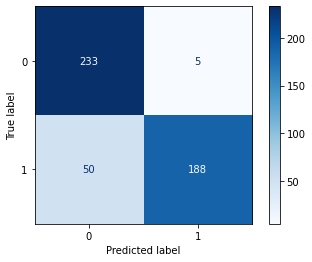

In [26]:
preds_pipe3 = gs_model_pipe3.predict(X_test)
plot_confusion_matrix(gs_model_pipe3, X_test, y_test, cmap='Blues', values_format='d');

In [27]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_pipe3).ravel()

print("\nAccuracy: ", (tn + tp) / (tn + fp + fn + tp))
df_results.loc[['Model 3'],['Accuracy']] = (tn + tp) / (tn + fp + fn + tp)

print("Sensitivity: ", tp / (tp + fn))
df_results.loc[['Model 3'],['Sensitivity']] = tp / (tp + fn)

print("Specificity: ", tn / (tn + fp))
df_results.loc[['Model 3'],['Specificity']] = tn / (tn + fp)

print("Precision: ", tp / (tp + fp))
df_results.loc[['Model 3'],['Precision']] = tp / (tp + fp)


Accuracy:  0.884453781512605
Sensitivity:  0.7899159663865546
Specificity:  0.9789915966386554
Precision:  0.9740932642487047


In [28]:
neg_class_prob_sorted = gs_model_pipe3.named_steps['mn3'].feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = gs_model_pipe3.named_steps['mn3'].feature_log_prob_[1, :].argsort()

print('Top 5 words for /rGainIt')
print(np.take(gs_model_pipe3.named_steps['tv3'].get_feature_names(), neg_class_prob_sorted[:5]))
print()
print('Top 5 words for /rLoseIt')
print(np.take(gs_model_pipe3.named_steps['tv3'].get_feature_names(), pos_class_prob_sorted[:5]))

Top 5 words for /rGainIt
['brag' 'lagging' 'seriously year' 'bad form' 'primary goal']

Top 5 words for /rLoseIt
['little worried' 'day step' 'day starting' 'pal' 'parent house']


Here it's interesting to observe that since the ngram of choice by the model is (1,2), we're seeing double words being utlized by MultinomialNB. The words may seem rather odd, but we can take into consideration that this due to the Lemmatizing effect. Overall there's quite high overfitting and we see that MultinomialNB does not do as well as Logistic Regression.

## Model 4: TfidfVectorizer, RandomForestClassifier

I thought that it'd be interesting to include Random Forest Classifier as well in the mix and see how it performs.

In [29]:
pipe4 = Pipeline([
    ('tv4', TfidfVectorizer(stop_words=stop_words_final)),
    ('rf4', RandomForestClassifier())
])

pipe4_params = {
    'tv4__min_df': [1, 2],
    'tv4__max_df': [0.95, 0.9],
    'tv4__ngram_range': [(1,1), (1,2)],
    'rf4__n_estimators': [100,150,200],
    'rf4__max_depth': [3,6,8,20,40]
}

gs_pipe4 = GridSearchCV(
    pipe4,
    param_grid=pipe4_params,
    cv=5
)

Fit model

In [30]:
gs_pipe4.fit(X_train, y_train);

In [31]:
gs_pipe4.best_score_

0.8932642487046631

In [32]:
gs_pipe4.best_params_

{'rf4__max_depth': 40,
 'rf4__n_estimators': 200,
 'tv4__max_df': 0.9,
 'tv4__min_df': 2,
 'tv4__ngram_range': (1, 1)}

In [33]:
gs_model_pipe4 = gs_pipe4.best_estimator_
gs_model_pipe4.score(X_train, y_train)

1.0

In [34]:
gs_model_pipe4.score(X_test, y_test)

0.884453781512605

### Metrics and scores

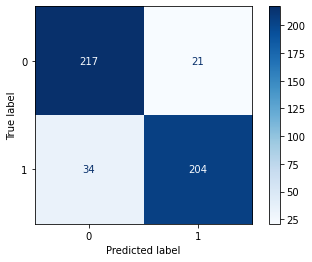

In [35]:
preds_pipe4 = gs_model_pipe4.predict(X_test)
plot_confusion_matrix(gs_model_pipe4, X_test, y_test, cmap='Blues', values_format='d');

In [36]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_pipe4).ravel()

print("\nAccuracy: ", (tn + tp) / (tn + fp + fn + tp))
df_results.loc[['Model 4'],['Accuracy']] = (tn + tp) / (tn + fp + fn + tp)

print("Sensitivity: ", tp / (tp + fn))
df_results.loc[['Model 4'],['Sensitivity']] = tp / (tp + fn)

print("Specificity: ", tn / (tn + fp))
df_results.loc[['Model 4'],['Specificity']] = tn / (tn + fp)

print("Precision: ", tp / (tp + fp))
df_results.loc[['Model 4'],['Precision']] = tp / (tp + fp)


Accuracy:  0.884453781512605
Sensitivity:  0.8571428571428571
Specificity:  0.9117647058823529
Precision:  0.9066666666666666


Finding out which are the more important words

In [37]:
rf4_model = gs_model_pipe4.named_steps['rf4']

important_features_dict = {}
for idx, val in enumerate(rf4_model.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print(np.take(gs_model_pipe4.named_steps['tv4'].get_feature_names(), important_features_list[:5]))

['weight' 'losing' 'journey' 'wa' 'bulking']


Random Forest Classifier is able to provide the features that gave the most importances and we can see these 5 words contributing the most to our model. 'weight', 'bulking' and 'rep' were words that we caught from EDA and it's interesting that Random Forest has selected the same important features as well.

## Model selection: TfidfVectorizer + LogReg 

To select the ideal model, we compare the models based on their confusion matrix.

In [38]:
df_results

,Accuracy,Sensitivity,Specificity,Precision
Model 1,0.909664,0.920168,0.89916,0.901235
Model 2,0.911765,0.878151,0.945378,0.941441
Model 3,0.884454,0.789916,0.978992,0.974093
Model 4,0.884454,0.857143,0.911765,0.906667


Using accuracy as a measure, Model 2 did the best with 91.1% accuracy and also scored 94.1% precision on unseen data. Model 1 came very close as well and it does signal that Logistic Regression seem to be doing a better job classifying the subreddits. Both Naives Bayes Classifier as well as Random Forest Classifer did relatively closely with about 89% accuracy scores. Though the disparity is not large, it was interesting to experiment running multiple models on the same dataset to see which one would prevail.

## Misclassification review

I wanted to take a look at what are the common misclassified posts to see if there's any interesting findings. We can do that by comparing the predicted results against the actual prediction per below.

In [64]:
y_pred1 = gs_model_pipe1.predict(X_test)
y_pred2 = gs_model_pipe2.predict(X_test)
y_pred3 = gs_model_pipe3.predict(X_test)
y_pred4 = gs_model_pipe4.predict(X_test)

misclassified1 = np.where(y_pred1 != y_test)
misclassified2 = np.where(y_pred2 != y_test)
misclassified3 = np.where(y_pred3 != y_test)
misclassified4 = np.where(y_pred4 != y_test)

raveled_1 = np.ravel(misclassified1).tolist()
raveled_2 = np.ravel(misclassified2).tolist()
raveled_3 = np.ravel(misclassified3).tolist()
raveled_4 = np.ravel(misclassified4).tolist()

misclassified = list(set(raveled_1) & set(raveled_2) & set(raveled_3) & set(raveled_4))

In [65]:
misclassified

[1,
 386,
 98,
 452,
 265,
 362,
 44,
 461,
 270,
 207,
 367,
 180,
 245,
 214,
 246,
 121,
 283]

In [71]:
X_test[386]

'protein powder question question may sound silly bugging like hear input people experience told protein powder cause weight gain even eating significant deficit exercising considerably long protein powder consumed weight loss realistic told calorie matter protein powder weight gain happen matter anyone add refute make sense case certain people ie female people thyroid problem woman pcos'

In [66]:
y_test[386]

0

In [72]:
X_test[98]

'fit shape skinny lifted day week consistently wa extremely shape biggest motivator wa looking good muscular know sound shallow wa college wa always skinny high school gaining weight loved r physique thought would never want change way look beginning year suddenly stopped going gym reason stopped lost muscle mass hate skinny look reason make go gym much want membership close time like motivation discipline lifting wa deleted brain slowly compounded le shape le energy make even harder go ha anyone run sudden loss discipline doe anyone advice bringing mindset back theory achieving goal many year bring motivational energy maybe second theory college motivator wa looking fit part social image longer feel need try anymore neither one make much sense still desire fit thing think'

In [67]:
y_test[98]

1

In [73]:
X_test[452]

'getting body fat hi everyone lost lb dirty bulk gained lb muscle bulk around body fat want get month weight loss wa losing lb month think weight loss ha slowed question much doe weight loss slow already lean visible six pack bf eating around calorie day min hiit session hour walking even every day still weight loss ha slowed heard weight loss rate slow even lb month think happens try get extreme level body fat competition ectomorph btw skinny fat side pure ripped ectomorph'

In [68]:
y_test[452]

0

Out of curiosity, I wanted to checkout a few misclassified posts. I took a look at 3 misclassified posts above. Interestingly, all 3 of them didn't seem straight up obvious as to where they should be classified under. 

## Feature Analysis

Given we've selected Model 2 as our model of choice, we want to take a look at the feature coefficients and see which were the most important words that aided the classification exercise.

In [ ]:
lr_model = gs_model_pipe2.named_steps['lr2']
tvec_model = gs_model_pipe2.named_steps['tv2']

df_coef = pd.DataFrame(lr_model.coef_.T, index=tvec_model.get_feature_names(), columns=['coefficient'])
df_coef['logodds'] = np.exp(df_coef['coefficient'])
df_coef.sort_values(by='coefficient', ascending=False).head(10)

In [ ]:
df_coef.sort_values(by='coefficient', ascending=False).tail(10)

Summarizing the top 5 words for each subreddit, we get below table.

|Model 2 (LogReg)|r/GainIt|r/LoseIt|
|---|---|---|
|1|bulking|decifit|
|2|bulk|losing weight|
|3|muscle|feel|
|4|squat|journey|
|5|rep|calorie|

For every one-unit increase in a word, the odds that the observation is in /rGainIt are the logodds value times as large as the odds that the observation is not in /rGainIt when all other variables are held constant. In other words, when the word 'bulking' appears in the post, it is 7 times as large as the odds that the word is not in /rGainIt. It's worthy to point out that despite our EDA identifying top words that occured in the subreddits, only 'muscle' and 'feel' came up.

It's interesting to observe that these words are very different when MultinomialNB is used as classifier. None of the words appeared in our EDA section. Let's take a look below

|Model 3 (MultinomialNB)|r/GainIt|r/LoseIt|
|---|---|---|
|1|brag|little worried|
|2|lagging|day step|
|3|seriously year|day starting|
|4|bad for|pal|
|5|primary goal|parent house|

In addition, we also have RandomForest that picked out these top 5 words as 'the most important' to the model. 

|Model 4 (RandomForest)|Important words|
|---|---|
|1|weight|
|2|wa|
|3|losing|
|4|journey|
|5|know|

## Conclusion

A total of 5 models were ran for this classifier project. Summary of their scores below

In [ ]:
df_results

Overall Model 2 performed the best if we compare on accuracy. Model 2 is a combination of TF-IDF Vectorizer alongside Logistic Regression. It was interesting to include additional classifiers like Naives Bayes and Random Forest to test and see how they performed. Though accuracy did not match up with Logistic Regression. Random Forest did not perform very well on all the confusion metrics, and my best guess is due to the sparsity of our dataset which probably made it unproductive for Random Forest on its random feature split.

In the problem statement I stated concerns regarding the similarity on the content of both subreddits. However, given that there were ample data for us to fit our model on, it turned out that our models performed relatively well on unseen data. Though there were similar keywords in both subreddits, there were distinct words within the subreddits which were sufficient to classify the subreddits respectively. Its noteworthy that each models placed different strength on different keywords. There were also keywords which I picked up from my initial EDA section that contributed well to the classifying model ('muscle', 'bulk', 'squat' etc). 

## Recommendations

If one wishes to strongly classify his or her Reddit post as part of r/GainIt, the model recommends to use this list of possible words in the body 
*('bulk', 'muscle', 'squat', 'rep', 'set', 'lift', 'program', 'bench', 'protein')*

If one wishes to strongly classify his or her Reddit post as part of r/LoseIt, the model recommends to use this list of possible words in the body
*('deficit', 'losing weight', 'feel', 'journey', 'calorie', 'want', 'losing', 'pound', 'weight')*

## Additional data points to consider



**1. User's geographical data**  
We can potentially patch in geographical data to test and see if there are regions in the world that are more interested in losing or gaining weight. Are Asians more inclined to weight gain as opposed to weight loss? Could this be a metric marketing companies can use to target their audience?
  
    
**2. User's gender data**  
Similar to above, we can also postulate and test to see if a specific gender is more inclined to gain or lose weight.